## Trabalho CPE722 - Treinamento Supervisionado 

Autor: Micael Veríssimo de Araújo

e-mail: micaelvero@hotmail.com

Utilizar o trainamento supervisionado exposto em sala na tentativa de obter uma classificação sinal (Higgs) e background ($t\overline{t}$) no canal $WH \to l \nu b \overline{b}$

## Load all libraries and data


In [72]:
# import all necessay library
%time
import numpy as np
from numpy import linalg as LA
from functions import ClusterMerits, AuxiliarFunctions
from sklearn import preprocessing
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn import metrics
import joblib

from functions import SupervisedKohonen
from sklearn import cross_validation

from pandas_ml import ConfusionMatrix

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [2]:
# load the data and little data
%time
data_path = '/home/micael/MyWorkspace/DATA'
path_tosave = data_path+'/'+'Plots'

# load signal
signal = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:5000,:]

signal_scd = preprocessing.scale(signal)
signal_part = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:250,:]
signal_trgt = np.ones(signal.shape[0])

# load bkg
ttbar = np.load(data_path+'/'+'TTbarMatrix.npy')
ttbar_scd = preprocessing.scale(ttbar)
ttbar_part = np.load(data_path+'/'+'TTbarMatrix.npy')[0:250,:]
bkg = ttbar
bkg_trgt = np.zeros(bkg.shape[0])

#to make a dataset and target
data = np.append(signal,bkg,axis=0)
data_scd = np.append(signal_scd,ttbar_scd,axis=0)
little_data = np.append(signal_part,ttbar_part,axis=0)
trgt = np.append(signal_trgt,bkg_trgt,axis=0).astype(int)#signal_scd
#trgt2 = trgt[:,np.newaxis] 

# to make correlation matrix
#data_trgt = np.append(data,trgt2,axis=1)
#data_trgt[:,24]
trgt

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


array([1, 1, 1, ..., 0, 0, 0])

In [43]:
data_noPtRel = np.delete(data,[11,23],axis=1)


In [48]:
# this cell normalize the data Caloba ways
norm_data = np.zeros_like(data_noPtRel)

scale_signal = preprocessing.StandardScaler().fit(data_noPtRel[trgt==1])
scale_ttbar = preprocessing.StandardScaler().fit(data_noPtRel[trgt==0])

norm_factor = np.zeros_like(scale_signal.scale_)
norm_factor = np.transpose(norm_factor)
for i in range(norm_factor.shape[0]):
    norm_factor[i] = min(scale_signal.scale_[i],scale_ttbar.scale_[i])

norm_data = preprocessing.scale(data_noPtRel,with_std=False)

for i in range(data_noPtRel.shape[1]):
    norm_data[:,i] = (1/norm_factor[i])*data_noPtRel[:,i]


norm_data = preprocessing.scale(data_noPtRel,with_std=False)

for i in range(norm_data.shape[1]):
    norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]
print np.mean(norm_data),np.std(norm_data)

9.07556857948e-18 1.03262573863


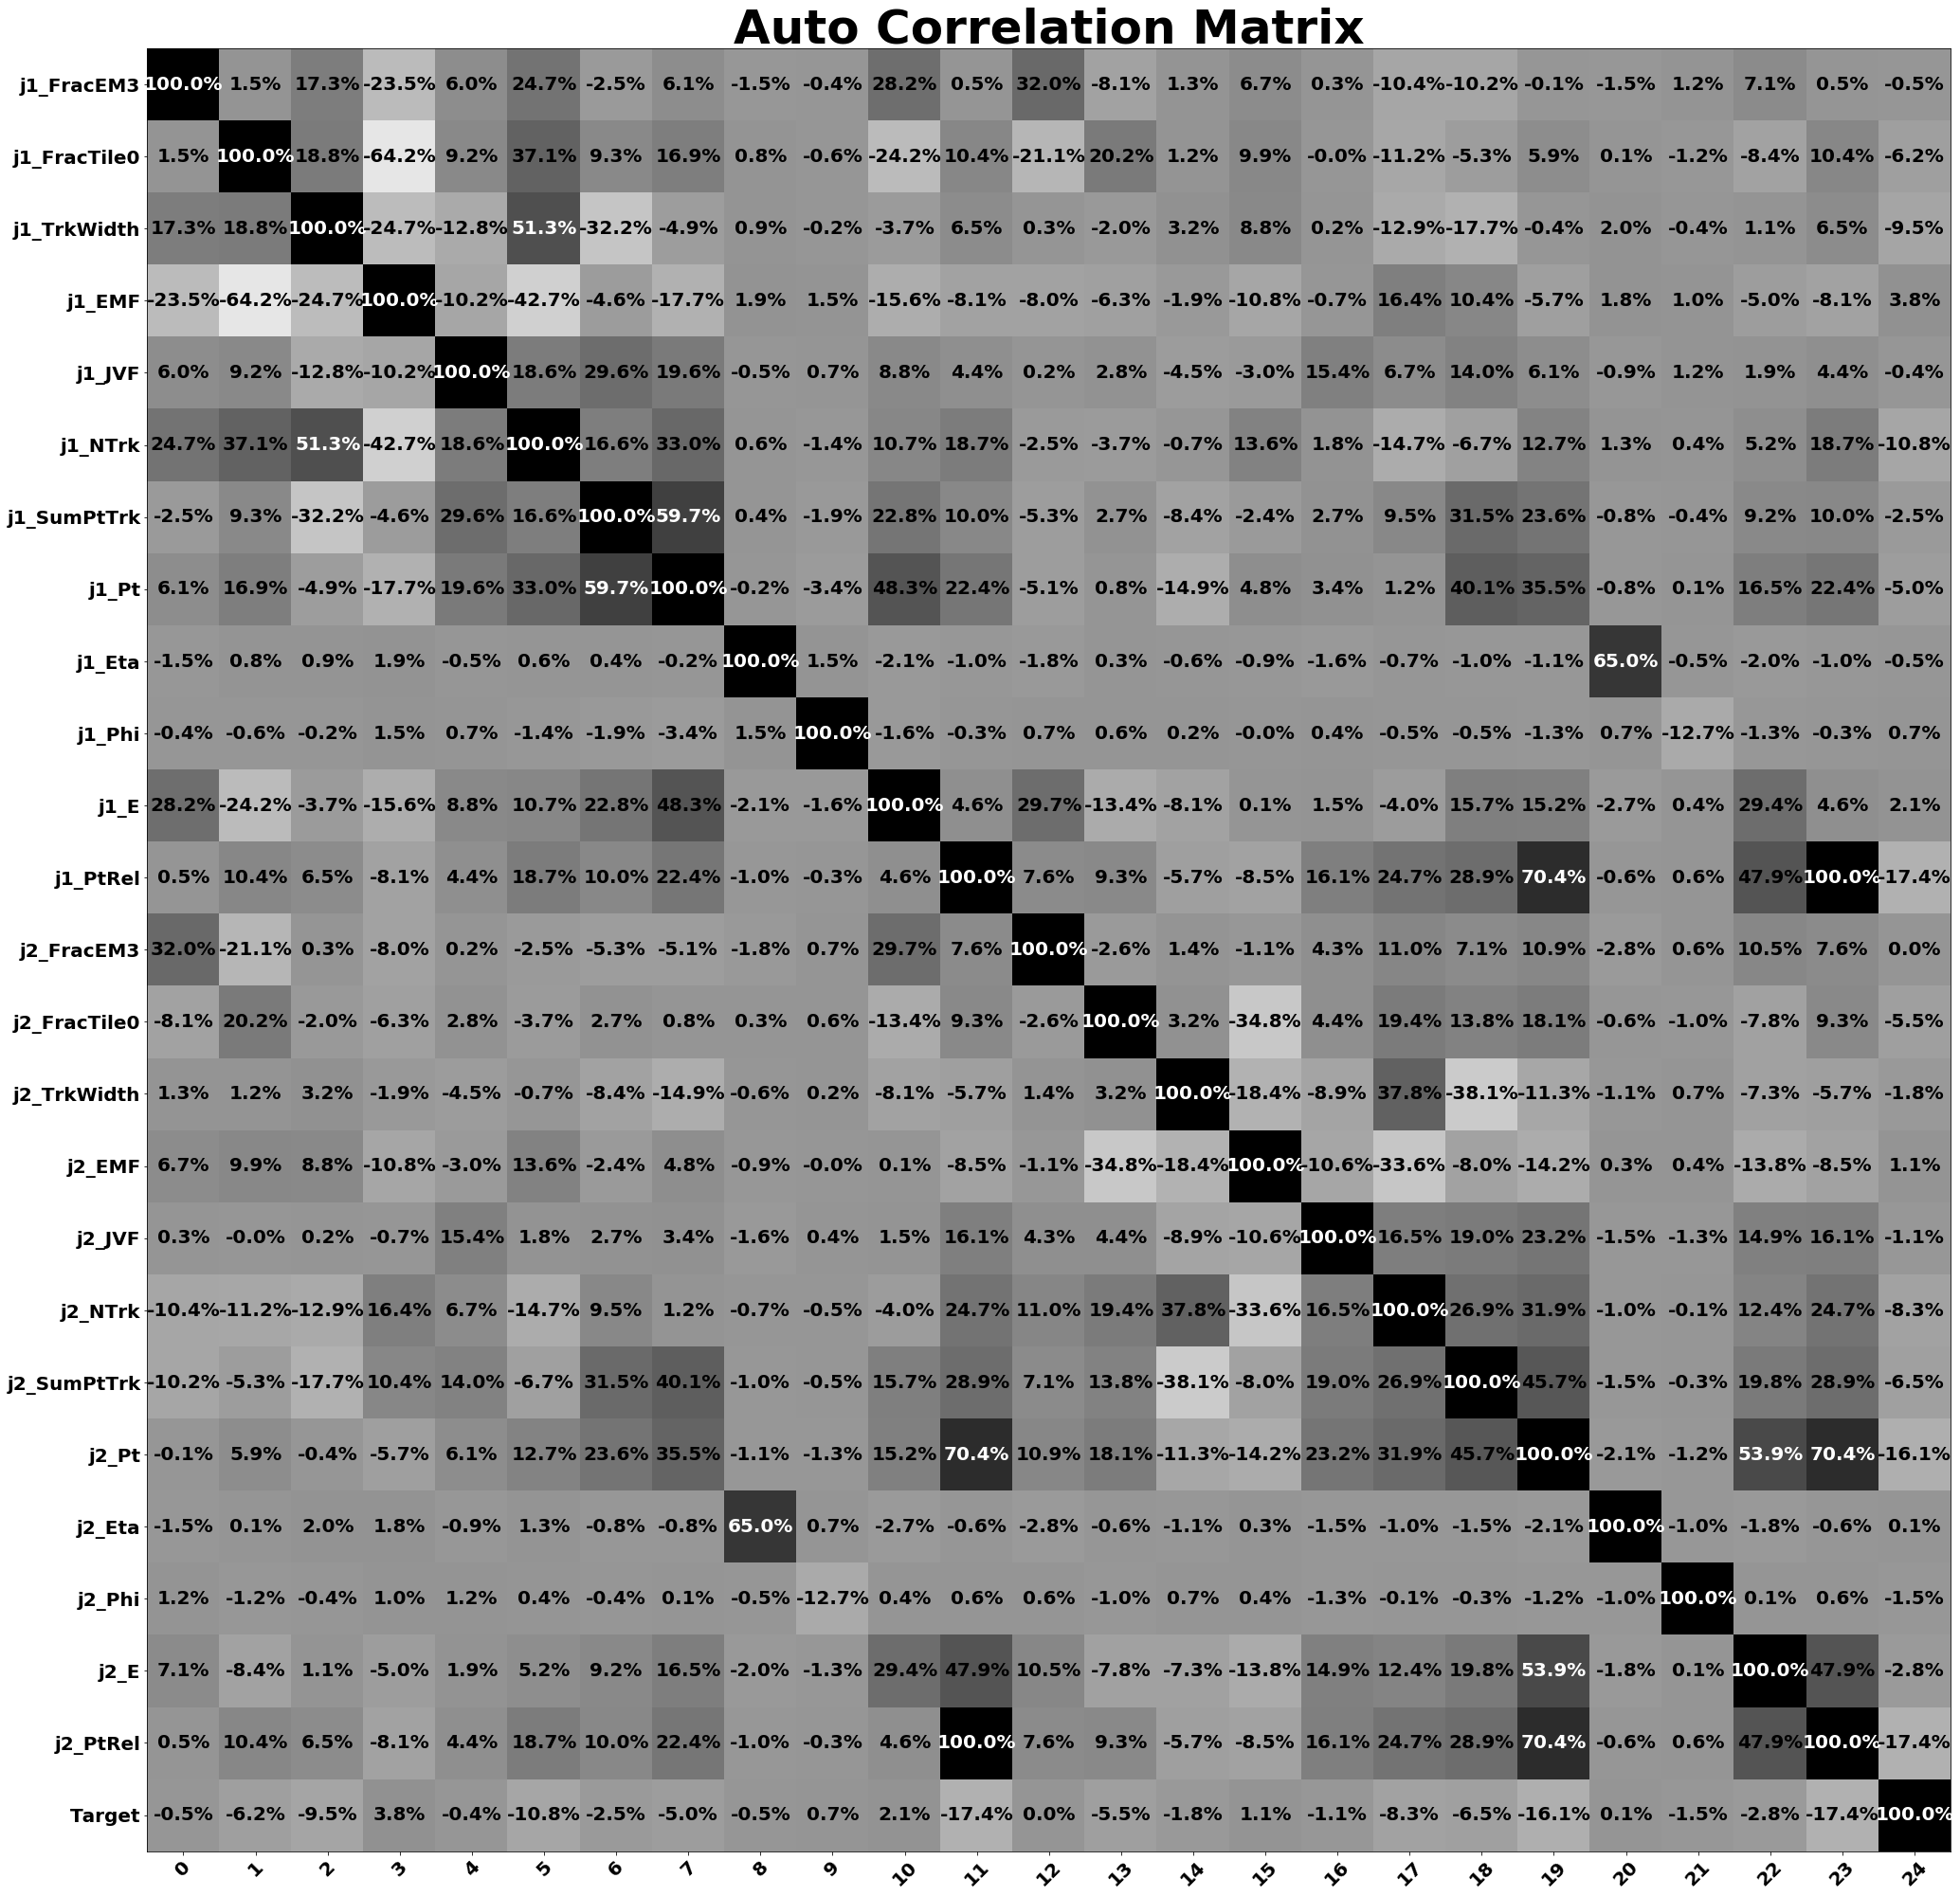

In [6]:
# Make a correlation matrix between variabels and target.

import matplotlib.pyplot as plt
%matplotlib inline 

#plt.rcParams['xtick.labelsize'] = 30
#plt.rcParams['ytick.labelsize'] = 30

plt.rc('legend', **{'fontsize':15})

plt.rc('font', weight='bold', size=20)

AutCor = 100.0*np.corrcoef(data_trgt,rowvar=0)

fig = plt.figure(figsize=(35,35))
ax = fig.add_subplot(111)
ax.set_aspect(1)
#cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]

AutoCor_Matrix = ax.imshow(AutCor,interpolation='nearest',cmap=plt.cm.Greys,clim=(-100.0, 100.0))

#fig.colorbar(AutoCor_Matrix)

width, height = AutCor.shape

for x in xrange(width):
    for y in xrange(height):
        if AutCor[x][y] < 50.:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center")
        else:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center",color="white")

ax.set_yticks(np.arange(AutCor.shape[1]))
ax.set_xticks(np.arange(AutCor.shape[0]))

labels = ['j1_FracEM3', 'j1_FracTile0', 'j1_TrkWidth', 'j1_EMF', 'j1_JVF', 'j1_NTrk', 'j1_SumPtTrk', 'j1_Pt', 'j1_Eta', 'j1_Phi', 'j1_E', 'j1_PtRel', 'j2_FracEM3', 'j2_FracTile0', 'j2_TrkWidth', 'j2_EMF', 'j2_JVF', 'j2_NTrk', 'j2_SumPtTrk', 'j2_Pt', 'j2_Eta', 'j2_Phi', 'j2_E', 'j2_PtRel','Target']

#ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=45)

ax.set_title('Auto Correlation Matrix', fontweight='bold', fontsize=50)
plt.savefig(path_tosave+'/'+'AutCorMatrixTRGT.pdf')

In [13]:
data_cut = data_trgt[:,[1,2,3,5,6,7,10,11,13,14,15,16,17,18,19,21,22,24]]

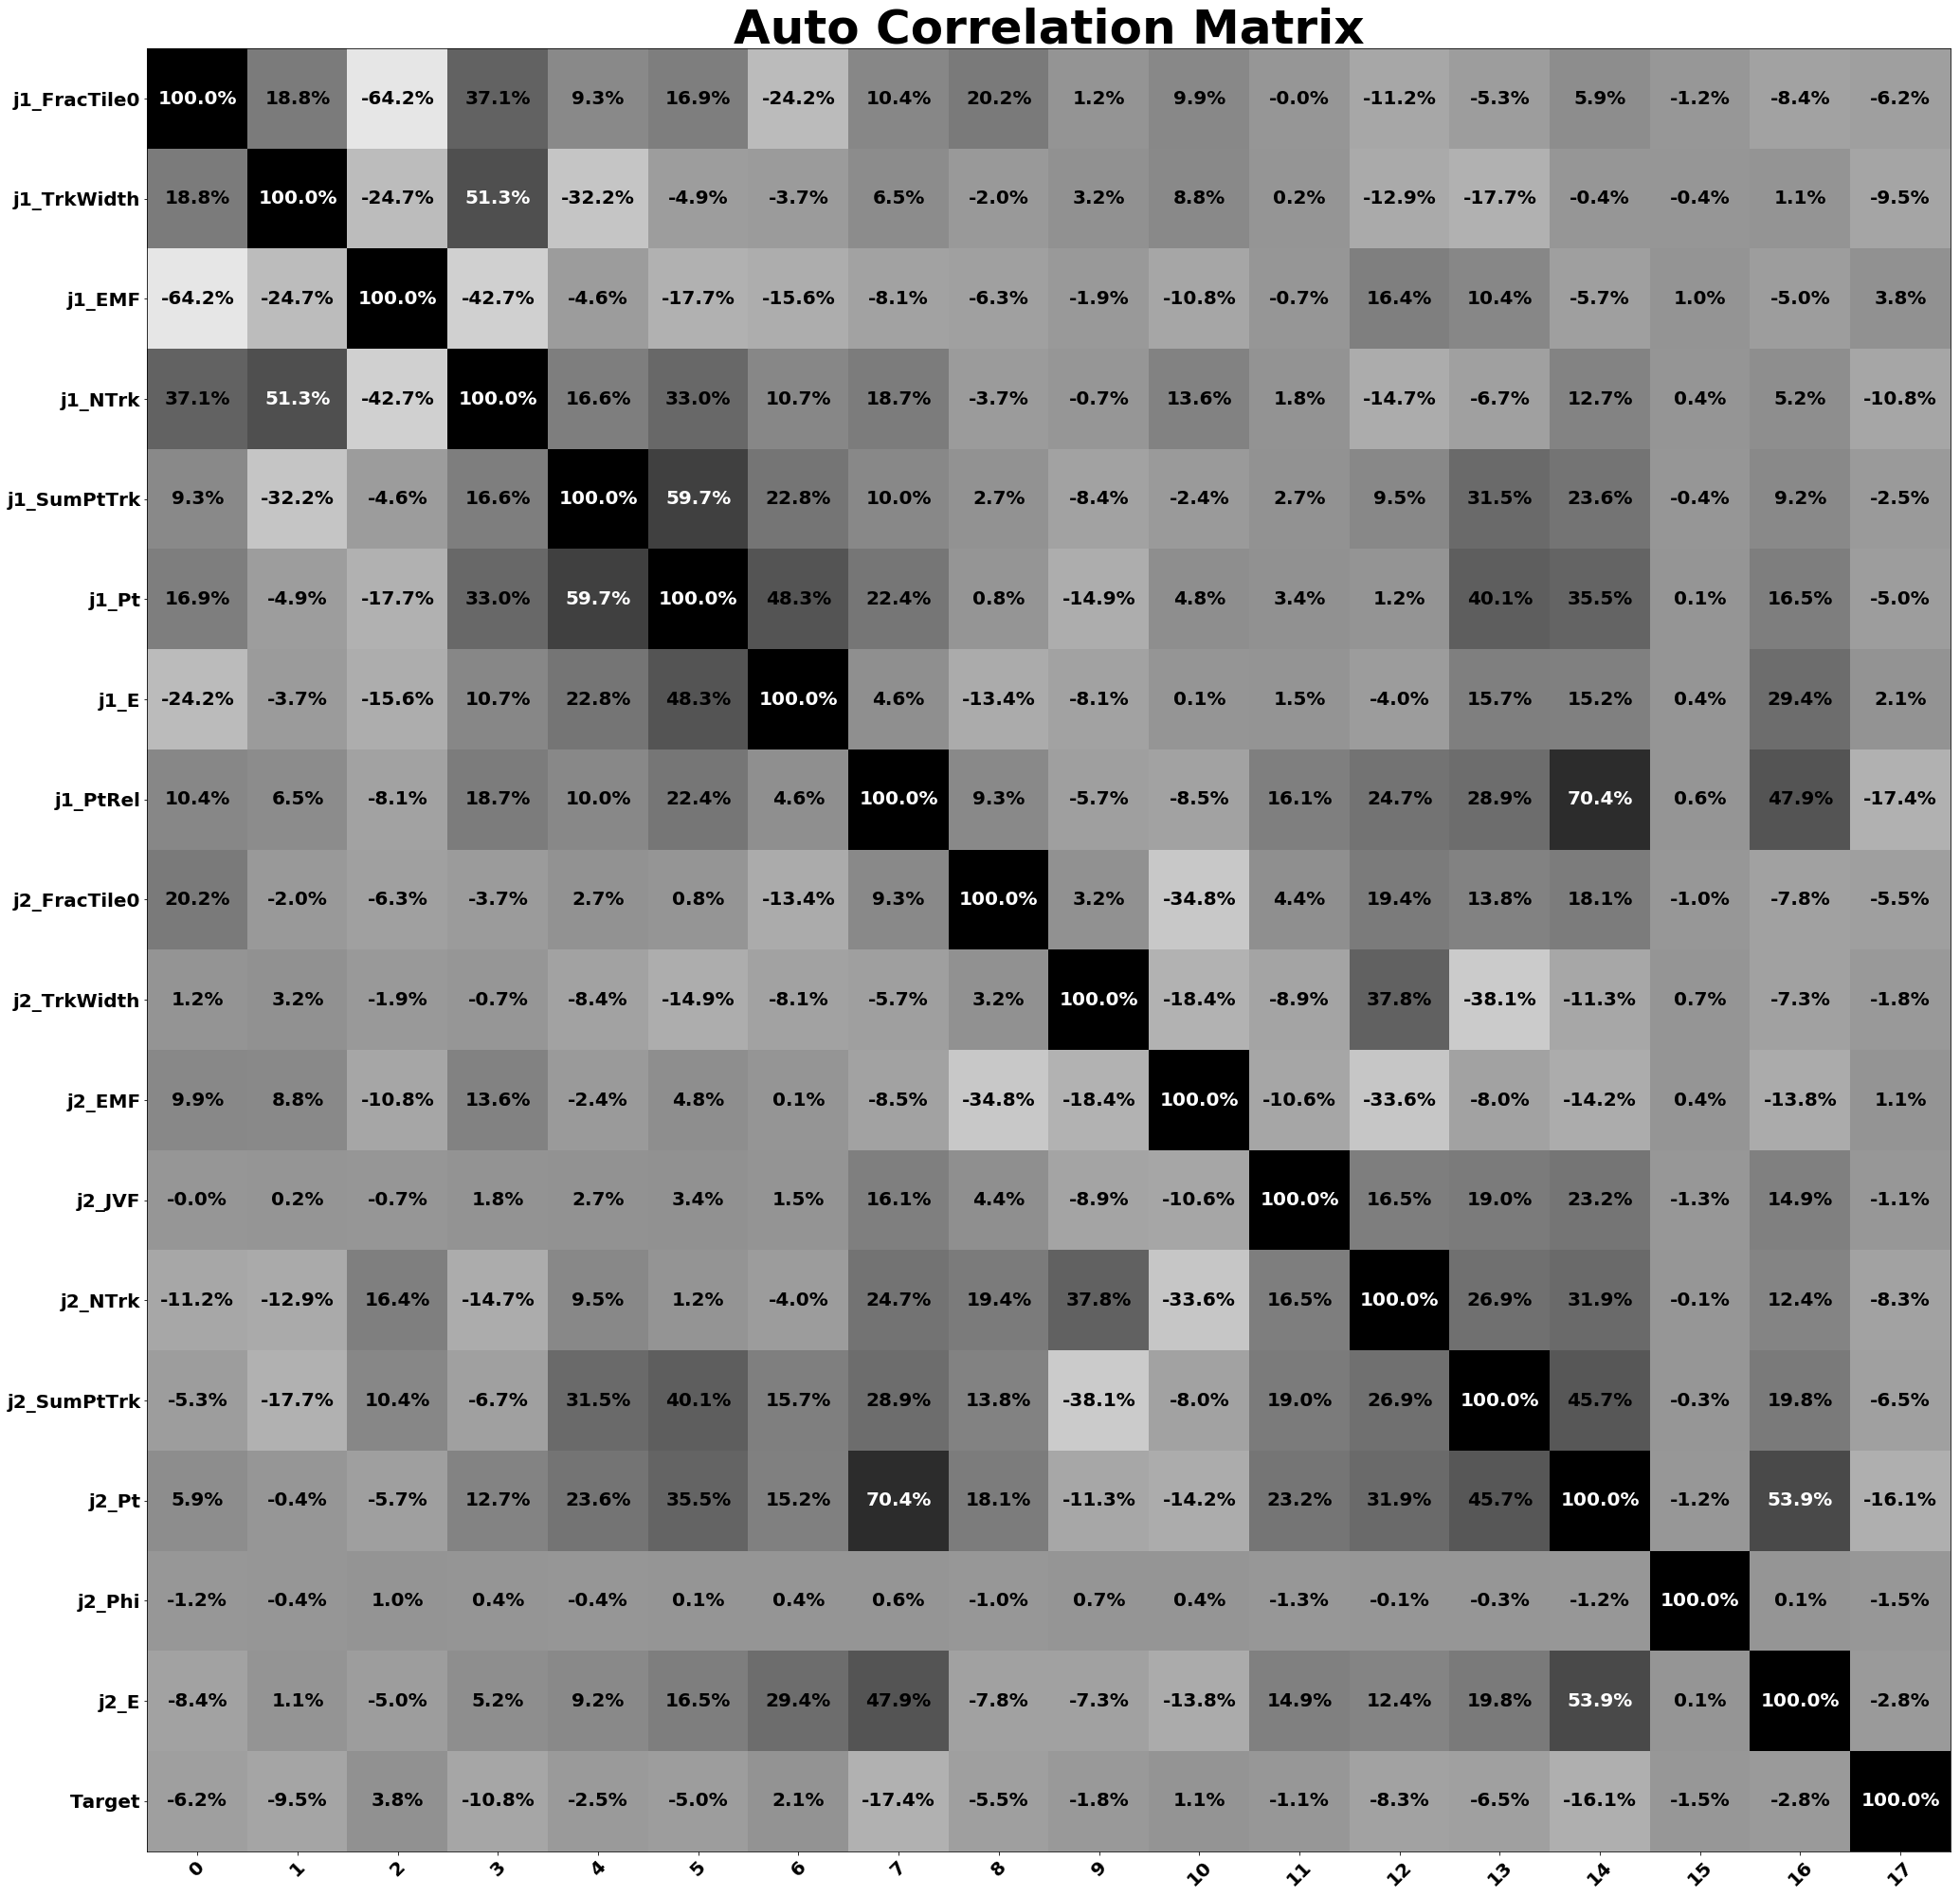

In [14]:
# Make a correlation matrix between variabels and target.

import matplotlib.pyplot as plt
%matplotlib inline 

#plt.rcParams['xtick.labelsize'] = 30
#plt.rcParams['ytick.labelsize'] = 30

plt.rc('legend', **{'fontsize':15})

plt.rc('font', weight='bold', size=20)

AutCor = 100.0*np.corrcoef(data_cut,rowvar=0)

fig = plt.figure(figsize=(35,35))
ax = fig.add_subplot(111)
ax.set_aspect(1)
#cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]

AutoCor_Matrix = ax.imshow(AutCor,interpolation='nearest',cmap=plt.cm.Greys,clim=(-100.0, 100.0))

#fig.colorbar(AutoCor_Matrix)

width, height = AutCor.shape

for x in xrange(width):
    for y in xrange(height):
        if AutCor[x][y] < 50.:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center")
        else:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center",color="white")

ax.set_yticks(np.arange(AutCor.shape[1]))
ax.set_xticks(np.arange(AutCor.shape[0]))

labels = ['j1_FracTile0', 'j1_TrkWidth', 'j1_EMF', 'j1_NTrk', 'j1_SumPtTrk', 'j1_Pt', 'j1_E', 'j1_PtRel', 'j2_FracTile0', 'j2_TrkWidth', 'j2_EMF', 'j2_JVF', 'j2_NTrk', 'j2_SumPtTrk', 'j2_Pt', 'j2_Phi', 'j2_E','Target']

#ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=45)

ax.set_title('Auto Correlation Matrix', fontweight='bold', fontsize=50)

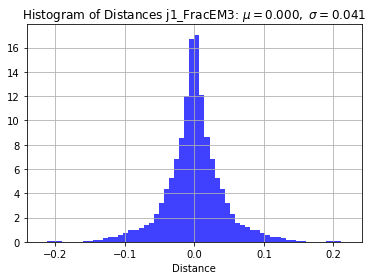

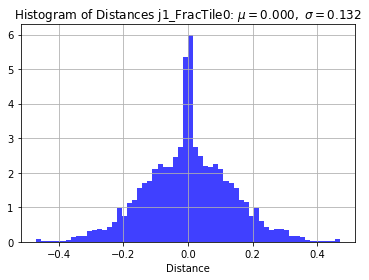

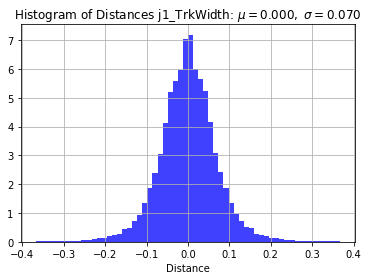

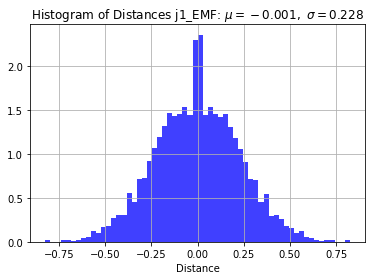

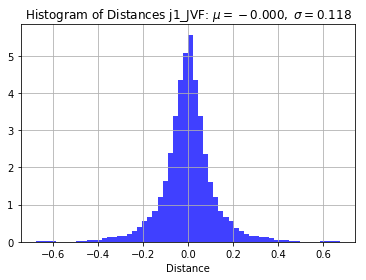

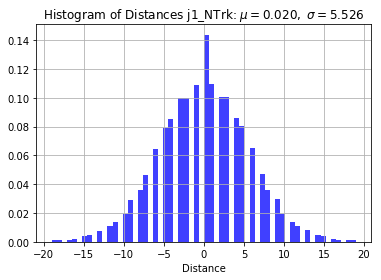

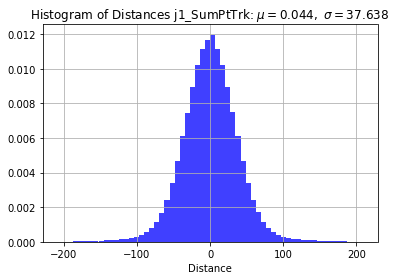

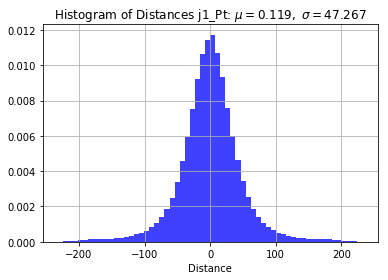

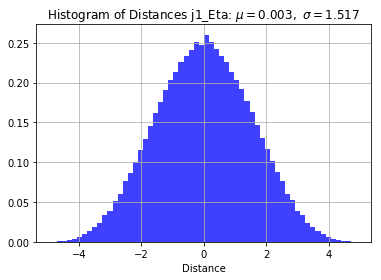

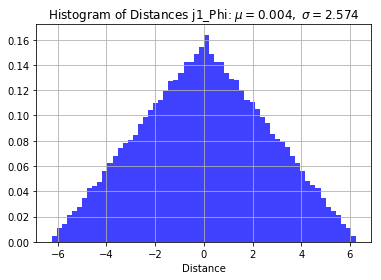

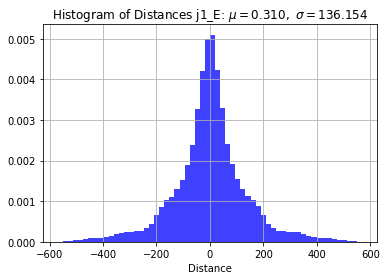

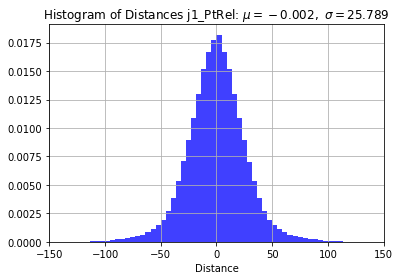

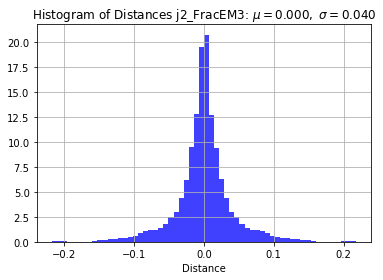

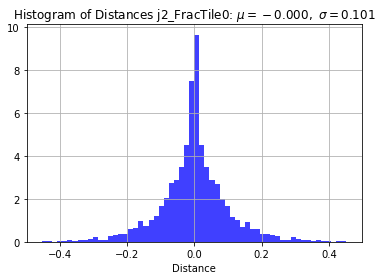

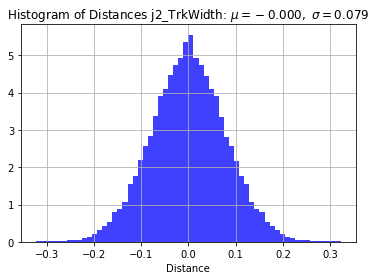

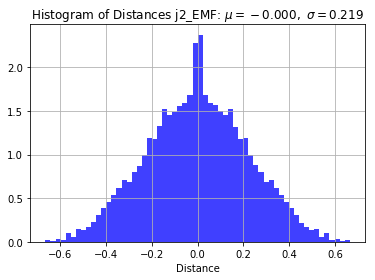

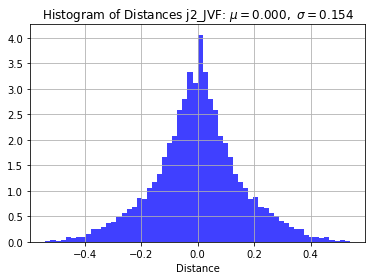

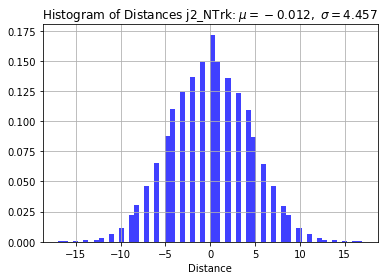

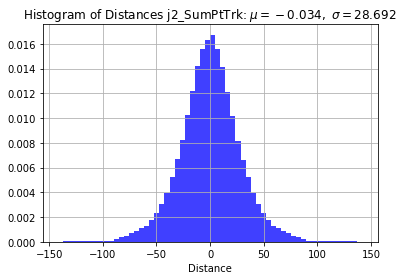

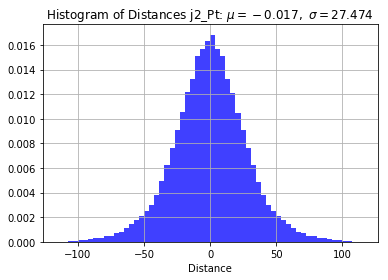

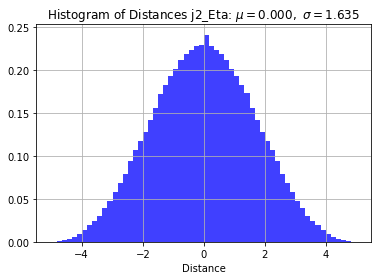

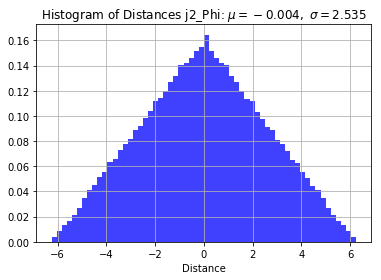

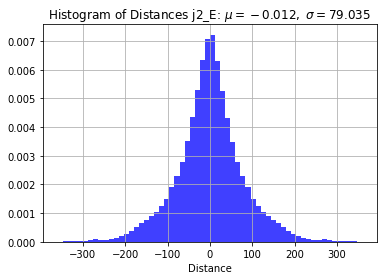

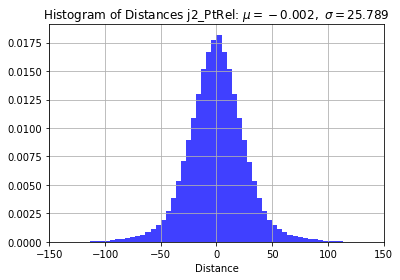

In [5]:
# distance histograms - use to estimate the sigma | better way?
variables = "j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,j1_Pt,j1_Eta,j1_Phi,j1_E,j1_PtRel,j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,j2_Pt,j2_Eta,j2_Phi,j2_E,j2_PtRel"
for variable,k in zip(variables.split(','),range(little_data.shape[1])):
    
    for i in range(little_data.shape[0]-1):
        for j in range(little_data.shape[0]):
            dist0 = little_data[i,k]-little_data[j,k]
            #dist1 = abs(little_data[i,k]-little_data[j,k])
            dataBuffer0 = np.array([dist0])
            #dataBuffer1 = np.array([dist1])
            if i==0:
                data0 = dataBuffer0
                #data1 = dataBuffer1
            else:
                data0 = np.append(data0,dataBuffer0, axis=0)
                #data1 = np.append(data1,dataBuffer1, axis=0)
            
    # best fit of data
    (mu, sigma) = norm.fit(data0)
    
    n, bins, patches = plt.hist(data0, 60, normed=1, facecolor='blue', alpha=0.75)
    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r', linewidth=2)
    #plt.xlim()
    #plot
    plt.xlabel('Distance')
    #plt.xlim(-sigma,sigma)
    plt.ylabel('')
    plt.title(r'Histogram of Distances '+variable+': $\mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

In [ ]:
# random data set for testing 

n_samples=200
n_features=2
centers=[[-2,-2],[2,2]] 
cluster_std=1.0

X, y = make_blobs(n_samples, n_features, centers, cluster_std,
                  random_state=None)
#X,y

In [ ]:
# histogram of distances
for k in range(X.shape[1]):
    
    for i in range(X.shape[0]-1):
        for j in range(X.shape[0]):
            dist0 = X[i,k]-X[j,k]
            dist1 = abs(X[i,k]-X[j,k])
            dataBuffer0 = np.array([dist0])
            dataBuffer1 = np.array([dist1])
            if i==0:
                data0 = dataBuffer0
                data1 = dataBuffer1
            else:
                data0 = np.append(data0,dataBuffer0, axis=0)
                data1 = np.append(data1,dataBuffer1, axis=0)
    # best fit of data
    (mu1, sigma1) = norm.fit(data0)
    
    n, bins, patches = plt.hist(data0, 60, normed=1, facecolor='green', alpha=0.75)
    # add a 'best fit' line
    y = mlab.normpdf( bins, mu1, sigma1)
    l = plt.plot(bins, y, 'r', linewidth=2)

    #plot
    plt.xlabel('Smarts')
    plt.ylabel('')
    plt.title(r'$\mathrm{Histogram\ of\ Distances:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu1, sigma1))
    plt.grid(True)

    #plt.show()
    #plt.subplot(211)
    #print 'desvio padrao ', np.std(data0)
    #plt.hist(data0,bins=60)
    #plt.subplot(212)
    #plt.hist(data1,bins=60)
    #plt.show()

## Trainamento Supervisionado nos dados utilizando uma camada simples de Kohonen

In [49]:
from functions import SupervisedKohonen
from sklearn import cross_validation
from sklearn.cluster import KMeans

n_folds = 10
n_clusters = 12
n_inits = 1


Acc_par = np.zeros([n_folds,len(range(0,n_clusters,2))])
SP_par = np.zeros([n_folds,len(range(0,n_clusters,2))])
Sil_par = np.zeros([n_folds,len(range(0,n_clusters,2))])

F_in = np.zeros([n_folds,len(range(0,n_clusters,2))])
F_out = np.zeros([n_folds,len(range(0,n_clusters,2))])

Acc_final = np.zeros([n_folds,len(range(0,n_clusters,2))])
SP_final = np.zeros([n_folds,len(range(0,n_clusters,2))])
Sil_final = np.zeros([n_folds,len(range(0,n_clusters,2))])
Acc_score_final = np.zeros([n_folds,len(range(0,n_clusters,2))])

    
range(0,n_clusters,2)
    

[0, 2, 4, 6, 8, 10]

In [50]:
for icluster in range(0,n_clusters,2):
    print '==============================',icluster,'======================================'
    trn_params = SupervisedKohonen.TrainParameters()
    trn_params.learning_rate = 0.01
    knn = SupervisedKohonen.KohonenNN()
    
    if icluster == 0:
        CVO = cross_validation.StratifiedKFold(trgt,n_folds)
        CVO = list(CVO)
        
        classifiers = {}
        
        for ifold in range(n_folds):
            train_id, test_id = CVO[ifold]
            for i_init in range(n_inits):
                print ('Processing: Fold %i of %i Init %i of %i'%(
                    ifold+1, n_folds, 
                    i_init+1, n_inits))        
                knn.fit(norm_data[train_id],trgt[train_id],trn_params=trn_params)
                classifiers[ifold] = knn
                knn_output = classifiers[ifold].predict(norm_data)
                
                cluster_list_icluster = [norm_data[knn_output==0],norm_data[knn_output==1]]
                
                Acc_final[ifold,icluster] = round(np.mean(ClusterMerits.Acc(knn_output[test_id],trgt[test_id])),3)
                Acc_score_final[ifold,icluster] = round(metrics.accuracy_score(trgt[test_id],knn_output[test_id]),3)
                SP_final[ifold,icluster] = round(ClusterMerits.SP(knn_output[test_id],trgt[test_id]),3)
                Sil_final[ifold,icluster] = round(metrics.silhouette_score(norm_data[test_id],knn_output[test_id]),3)
                
                F_in[ifold,icluster] = round(ClusterMerits.DispIntraClass(cluster_list_icluster),3)
                F_out[ifold,icluster] = round(abs(F_in[ifold,icluster]-ClusterMerits.DispTotal(norm_data)))
                
                
    else:
        
        data_signal = norm_data[trgt==1]
        data_ttbar = norm_data[trgt==0]
        ttbar_n_clusters=icluster
        signal_n_clusters=icluster
        kmeans_signal = KMeans(n_clusters=signal_n_clusters, random_state=0).fit_predict(data_signal)
        kmeans_ttbar = KMeans(n_clusters=ttbar_n_clusters, random_state=0).fit_predict(data_ttbar)
        
        new_trgt = np.append((kmeans_signal+ttbar_n_clusters),kmeans_ttbar)
        
        CVO = cross_validation.StratifiedKFold(new_trgt,n_folds)
        CVO = list(CVO)
        
        classifiers = {}
        
        for ifold in range(n_folds):
            train_id, test_id = CVO[ifold]
            for i_init in range(n_inits):
                print ('Processing: Fold %i of %i Init %i of %i'%(
                    ifold+1, n_folds, 
                    i_init+1, n_inits))        
                knn.fit(norm_data[train_id],new_trgt[train_id],trn_params=trn_params)
                classifiers[ifold] = knn
                knn_output = classifiers[ifold].predict(norm_data)
                
                Acc_par[ifold,int(icluster/2)] = round(np.mean(ClusterMerits.Acc(knn_output[test_id],new_trgt[test_id])),3)
                SP_par[ifold,int(icluster/2)] = round(ClusterMerits.SP(knn_output[test_id],new_trgt[test_id]),3)
                Sil_par[ifold,int(icluster/2)] = round(metrics.silhouette_score(norm_data[test_id],knn_output[test_id]),3)
                
                cluster_list_icluster = [norm_data[knn_output==i] for i in range(new_trgt.shape[0])]
                
                F_in[ifold,int(icluster/2)] = round(ClusterMerits.DispIntraClass(cluster_list_icluster),3)
                F_out[ifold,int(icluster/2)] = round(abs(F_in[ifold,int(icluster/2)]-ClusterMerits.DispTotal(norm_data)),3)
                
                class_final = np.zeros(trgt.shape)
                for i in range(knn_output.shape[0]):
                    if knn_output[i] in range(ttbar_n_clusters):
                        class_final[i]=0
                    else:
                        class_final[i]=1
                
                Acc_final[ifold,int(icluster/2)] = round(np.mean(ClusterMerits.Acc(class_final[test_id],trgt[test_id])),3)
                Acc_score_final[ifold,int(icluster/2)] = round(metrics.accuracy_score(trgt[test_id],knn_output[test_id]),3)
                SP_final[ifold,int(icluster/2)] = round(ClusterMerits.SP(class_final[test_id],trgt[test_id]),3)
                Sil_final[ifold,int(icluster/2)] = round(metrics.silhouette_score(norm_data[test_id],class_final[test_id]),3)


============================== 0 ======================================
Processing: Fold 1 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 2 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 3 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 4 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 5 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 6 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 7 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False

Processing: Fold 9 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9006
Processing: Fold 10 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9010


In [71]:
Acc_score_final

array([[ 0.574,  0.173,  0.188,  0.107,  0.086,  0.032],
       [ 0.536,  0.181,  0.202,  0.133,  0.079,  0.033],
       [ 0.582,  0.193,  0.184,  0.125,  0.069,  0.03 ],
       [ 0.57 ,  0.176,  0.189,  0.118,  0.067,  0.029],
       [ 0.561,  0.188,  0.183,  0.108,  0.055,  0.035],
       [ 0.561,  0.186,  0.185,  0.11 ,  0.053,  0.032],
       [ 0.573,  0.167,  0.186,  0.118,  0.065,  0.034],
       [ 0.582,  0.159,  0.183,  0.126,  0.069,  0.032],
       [ 0.559,  0.17 ,  0.181,  0.118,  0.07 ,  0.03 ],
       [ 0.552,  0.183,  0.18 ,  0.123,  0.06 ,  0.028]])

In [52]:
# accuracia media
acc_mean = np.zeros([Acc_final.shape[1],])
sigma_acc = np.zeros([Acc_final.shape[1],])

for i in range(acc_mean.shape[0]):
    acc_mean[i] = np.mean(Acc_final[:,i])
    sigma_acc[i] = np.std(Acc_final[:,i])

acc_score_mean = np.zeros([Acc_score_final.shape[1],])
sigma_acc_score = np.zeros([Acc_score_final.shape[1],])

for i in range(acc_score_mean.shape[0]):
    acc_score_mean[i] = np.mean(Acc_score_final[:,i])
    sigma_acc_score[i] = np.std(Acc_score_final[:,i])

# f_in medio
Fin_mean = np.zeros([F_in.shape[1],])
sigma_Fin = np.zeros([F_in.shape[1],])

for i in range(Fin_mean.shape[0]):
    Fin_mean[i] = np.mean(F_in[:,i])
    sigma_Fin[i] = np.std(F_in[:,i])
    
# F_out medio
Fout_mean = np.zeros([F_out.shape[1],])
sigma_Fout = np.zeros([F_out.shape[1],])

for i in range(Fout_mean.shape[0]):
    Fout_mean[i] = np.mean(F_out[:,i])
    sigma_Fout[i] = np.std(F_out[:,i])

# media do indice SP
SP_mean = np.zeros([SP_final.shape[1],])
sigma_SP = np.zeros([SP_final.shape[1],])

for i in range(SP_mean.shape[0]):
    SP_mean[i] = np.mean(SP_final[:,i])
    sigma_SP[i] = np.std(SP_final[:,i])

# media silhueta 
sil_mean = np.zeros([Sil_final.shape[1],])
sigma_sil = np.zeros([Sil_final.shape[1],])

for i in range(sil_mean.shape[0]):
    sil_mean[i] = np.mean(Sil_final[:,i])
    sigma_sil[i] = np.std(Sil_final[:,i])


sigma_Fin

array([ 1691.30018778,   601.00948573,   403.95130252,   361.28779759,
         249.03834818,   235.83723178])

In [35]:
acc_par_mean = np.zeros([Acc_par.shape[1],])
sigma_par_acc = np.zeros([Acc_par.shape[1],])

for i in range(acc_par_mean.shape[0]):
    acc_par_mean[i] = np.mean(Acc_par[:,i])
    sigma_acc[i] = np.std(Acc_par[:,i])


SP_par_mean = np.zeros([SP_par.shape[1],])
sigma_par_SP = np.zeros([SP_par.shape[1],])

for i in range(SP_mean.shape[0]):
    SP_par_mean[i] = np.mean(SP_par[:,i])
    sigma_par_SP[i] = np.std(SP_par[:,i])

    
sil_par_mean = np.zeros([Sil_par.shape[1],])
sigma_par_sil = np.zeros([Sil_par.shape[1],])

for i in range(sil_par_mean.shape[0]):
    sil_par_mean[i] = np.mean(Sil_par[:,i])
    sigma_par_sil[i] = np.std(Sil_par[:,i])


In [54]:
# x axis for plot
x = np.array([2,4,8,12,16,20])
x

array([ 2,  4,  8, 12, 16, 20])

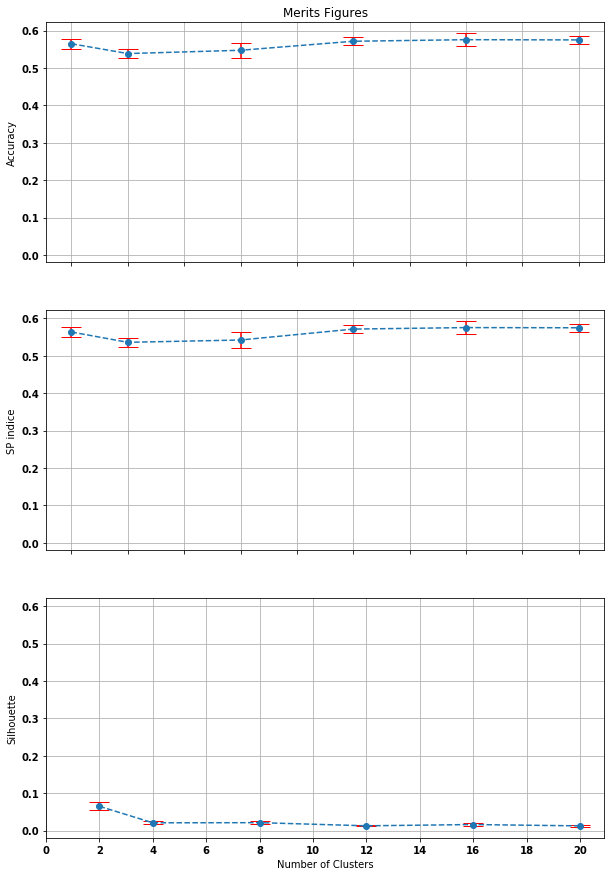

In [55]:
plt.figure(figsize=(10,10))

f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15), sharex=True, sharey=True)
ax1.errorbar(x, acc_mean, yerr=sigma_acc, fmt='--o',ecolor='r',capsize=10)
ax1.grid()
ax1.set_title('Merits Figures')
ax1.set_ylabel('Accuracy')
ax2.errorbar(x,SP_mean, yerr=sigma_SP, fmt='--o',ecolor='r',capsize=10)
ax2.set_ylabel('SP indice')
ax2.grid()
ax3.errorbar(x,sil_mean, yerr=sigma_sil,fmt='--o',ecolor='r',capsize=10)
ax3.set_ylabel('Silhouette')
ax3.grid()
ax3.set_xlabel('Number of Clusters')
ax3.set_xticks(np.arange(min(x)-2, max(x)+1, 2.0))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
#f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.savefig(path_tosave+'/'+'figuras_3em1_semPtRel.pdf')

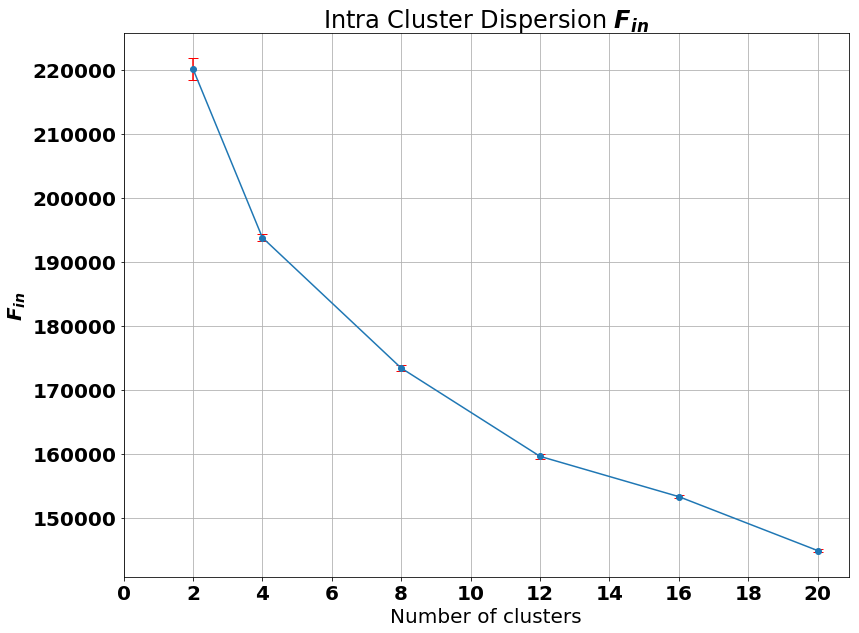

In [56]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fin_mean,yerr=sigma_Fin,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Intra Cluster Dispersion $F_{in}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{in}$')
plt.grid()
plt.savefig(path_tosave+'/'+'Fin_plot_semPtRel.pdf')

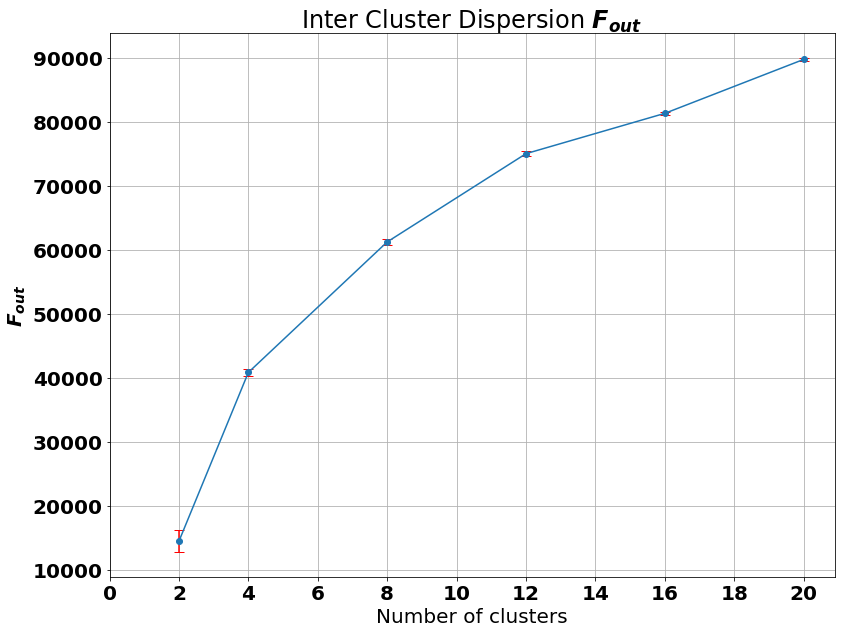

In [57]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fout_mean,yerr=sigma_Fout,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Inter Cluster Dispersion $F_{out}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{out}$')
plt.grid()
plt.savefig(path_tosave+'/'+'Fout_plot_semPtRel.pdf')

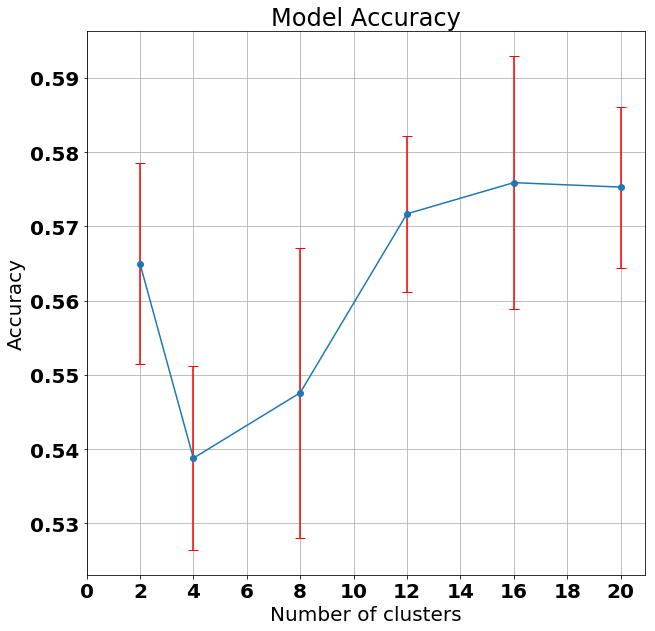

In [58]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.errorbar(x,acc_mean,yerr=sigma_acc,ecolor='r',fmt='-o',capsize=5)
plt.title('Model Accuracy')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('Accuracy')
plt.grid()
plt.savefig(path_tosave+'/'+'Accuracy_plot_semPtRel.pdf')

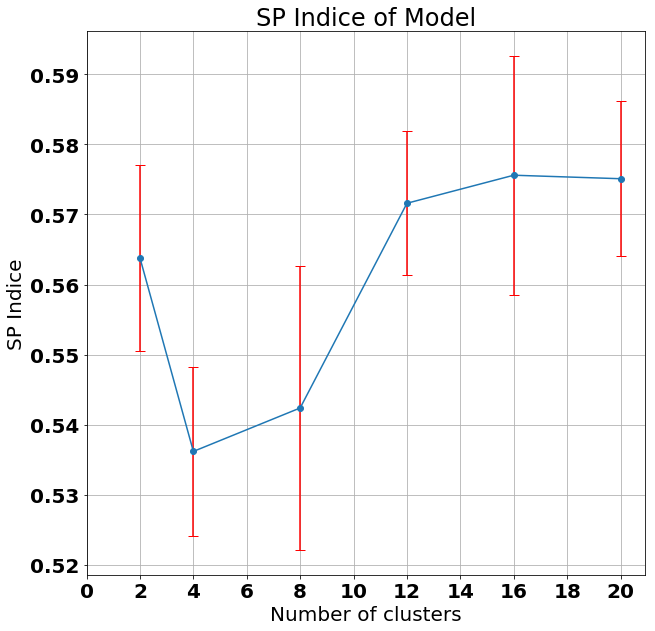

In [59]:
plt.figure(figsize=(10,10))
plt.errorbar(x,SP_mean,yerr=sigma_SP,ecolor='r',fmt='-o',capsize=5)
plt.title('SP Indice of Model')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('SP Indice')
plt.grid()
plt.savefig(path_tosave+'/'+'SPindex_plot_semPtRel.pdf')

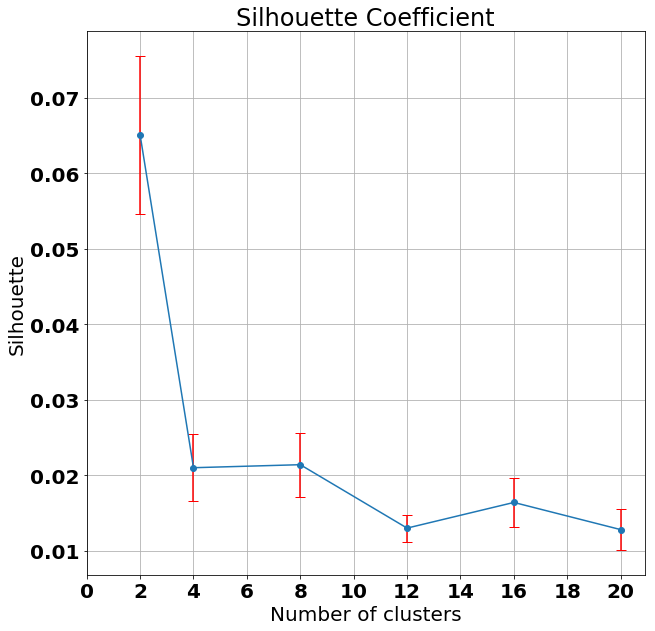

In [60]:
plt.figure(figsize=(10,10))
plt.errorbar(x,sil_mean,yerr=sigma_sil,ecolor='r',fmt='-o',capsize=5)
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('Silhouette')
plt.grid()
plt.savefig(path_tosave+'/'+'Silhouette_plot_semPtRel.pdf')

## Número de Clusters definido igual 8 ( 4 clusters para sinal e 4 clusters para ruído )

Treinamento e obtenção do resultado e matriz de confusão

In [61]:
# try to use the SupervisedKohonen 

from functions import SupervisedKohonen
from sklearn import cross_validation

trn_params = SupervisedKohonen.TrainParameters()

trn_params.learning_rate = 0.01

knn = SupervisedKohonen.KohonenNN()

In [62]:
data_signal = norm_data[trgt==1]
data_ttbar = norm_data[trgt==0]
ttbar_n_clusters=6
signal_n_clusters=6
kmeans_signal = KMeans(n_clusters=signal_n_clusters, random_state=0).fit_predict(data_signal)
kmeans_ttbar = KMeans(n_clusters=ttbar_n_clusters, random_state=0).fit_predict(data_ttbar)

new_trgt = np.append((kmeans_signal+ttbar_n_clusters),kmeans_ttbar)

np.unique(new_trgt)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [63]:
n_folds = 10
n_inits = 1

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}

for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))        
        knn.fit(norm_data[train_id],new_trgt[train_id],trn_params=trn_params)
        classifiers[ifold] = knn

Processing: Fold 1 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 2 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 3 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 4 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 5 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 6 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 7 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 8 of 10 Init 1 of 1
Supervised 

In [ ]:
# not work
# all classifiers saved
knn.save_model(data_path+'/'+'model_2clusters.pk1')

In [ ]:
teste = joblib.load(data_path+'/'+'model_2clusters.pk1')

teste.sinapses

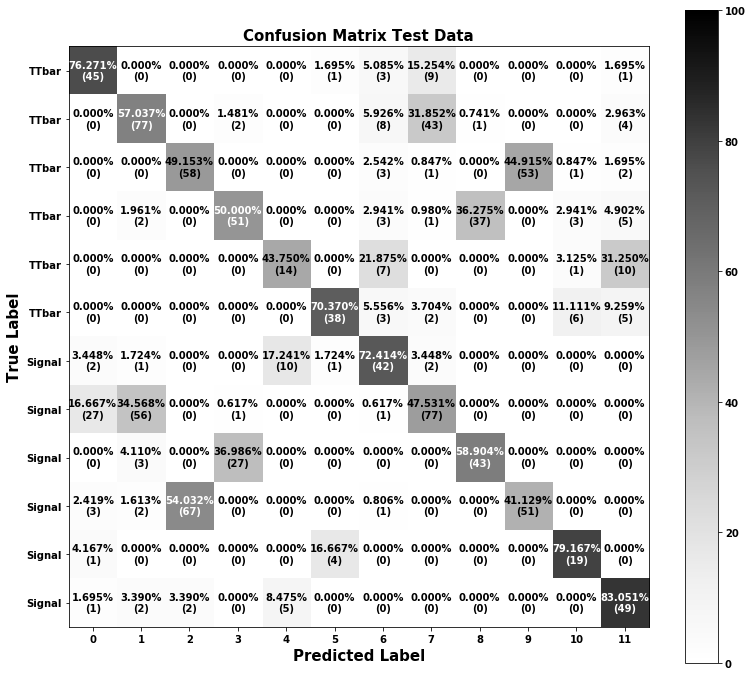

In [65]:
# confusion matrix for supervised Kohonen

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

data_labels = ['TTbar','TTbar','TTbar','TTbar','TTbar','TTbar','Signal','Signal','Signal','Signal','Signal','Signal']
plt.rcParams['font.weight'] = 'bold'
#output_class = Output
choose_fold = 0
#print 'Fold: ', choose_fold
train_id, test_id = CVO[choose_fold]

knn_output = classifiers[choose_fold].predict(norm_data)

#SP = ClusterMerits.SP(Output,trgt)
#print 'SP = ', SP

#acc = np.mean(ClusterMerits.Acc(Output,trgt))
#print 'Accuracy', acc

cm = confusion_matrix(new_trgt[test_id], knn_output[test_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Test Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
#ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_12clustersTEST_ResultnoPtRel.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

In [61]:
cluster_matrix = ConfusionMatrix(new_trgt[test_id], knn_output[test_id])
print norm_data[trgt[test_id]==0].shape[0]
print("Confusion matrix:\n%s" % cluster_matrix)

501
Confusion matrix:
Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  __all__
Actual                                                    
0.0         71    0    0    0    2   26    0    9      108
1.0          0   35    0    0    0    0    0    0       35
2.0          0    0   85    0   12    0   58   50      205
3.0          0    1    0  115    7    3    0   27      153
4.0          1    0    0    1   42    1    0    0       45
5.0         40    0    0    2    0   84    0    0      126
6.0          0    0   63    0    0    0   74    0      137
7.0          0    0   11   22    0    1    4  156      194
__all__    112   36  159  140   63  115  136  242     1003


/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1003
  


In [156]:
acc = np.mean(ClusterMerits.Acc(knn_output,new_trgt))
print 'Accuracy: ', round(acc,3)

print 'Acc Score: ', round(metrics.accuracy_score(knn_output,new_trgt),3)

SP = ClusterMerits.SP(knn_output,new_trgt)
print 'SP: ', round(SP,3)

Sil = metrics.silhouette_score(norm_data,new_trgt)
print 'Silhueta: ', round(Sil,3)

Accuracy:  0.719
Acc Score:  0.632
SP:  0.704
Silhueta:  0.016


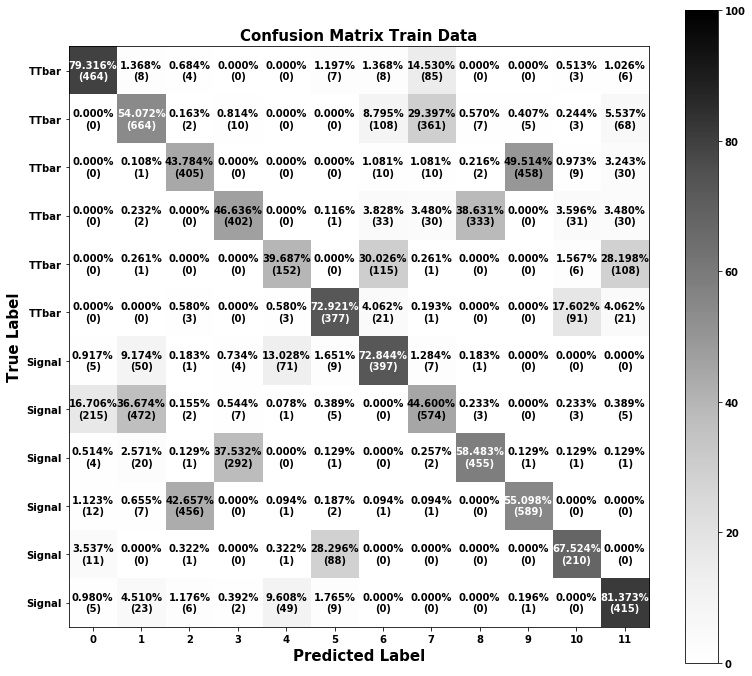

In [66]:
cm = confusion_matrix(new_trgt[train_id], knn_output[train_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Train Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
#ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_12clustersTRAIN_ResultnoPtRel.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_5clustersttbar-4clustersignalTRAIN_BACKUP.pdf')

In [67]:
# create a final classification for signal and bkg

class_final = np.zeros(trgt.shape)
for i in range(knn_output.shape[0]):
    if knn_output[i] in range(ttbar_n_clusters):
        #print 'bkg'
        class_final[i]=0
    else:
        #print 'signal'
        class_final[i]=1
        
np.unique(class_final)


array([ 0.,  1.])

In [73]:
# merit figures
print 'Acc: ', round(np.mean(ClusterMerits.Acc(class_final,trgt)),3)
print 'Acc Score:', round(metrics.accuracy_score(trgt[test_id],class_final[test_id]),3)
print 'Indice SP: ',round(ClusterMerits.SP(class_final,trgt),3)
print 'Silhuet Coeficient: ',round(metrics.silhouette_score(norm_data,class_final),3)
#print 'Acuracy_score: ', metrics.accuracy_score(trgt,class_final)
#print 'completness score: ', metrics.completeness_score(trgt,class_final)
print 'v mesure: ', metrics.v_measure_score(trgt,class_final)

Acc:  0.575
Acc Score: 0.573
Indice SP:  0.574
Silhuet Coeficient:  0.018
v mesure:  0.0161400003997


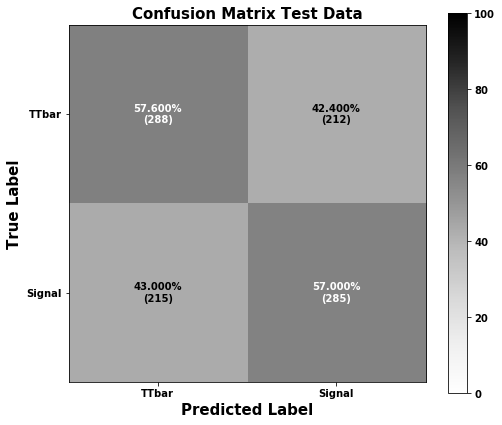

In [69]:
data_labels = ['TTbar','Signal']
plt.rcParams['font.weight'] = 'bold'

cm = confusion_matrix(trgt[test_id], class_final[test_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Test Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_12clustersTEST_ResultnPtRel.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

0.6822709163346613

In [67]:

conf_matrix = ConfusionMatrix(trgt[test_id], class_final[test_id])
print("Confusion matrix:\n%s" % conf_matrix)
#conf_matrix.print_stats()

Confusion matrix:
Predicted  0.0  1.0  __all__
Actual                      
0.0        307  194      501
1.0        140  362      502
__all__    447  556     1003


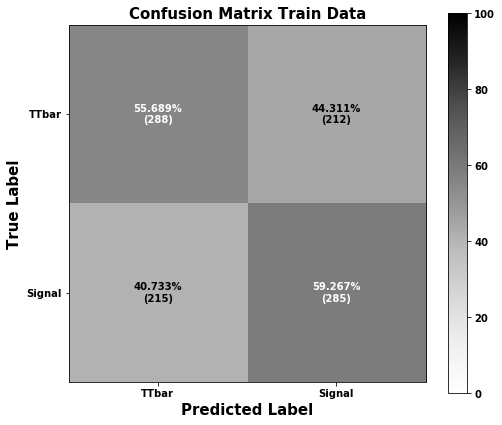

In [70]:
cm = confusion_matrix(trgt[train_id], class_final[train_id])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Train Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_12clustersTRAIN_ResultnoPtRel.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTRAIN_BACKUP.pdf')

In [ ]:
print class_final[test_id].shape
np.sum(class_final[trgt[test_id]==-1]==-1)/float(501)

/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  # This is added back by InteractiveShellApp.init_path()
/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  if sys.path[0] == '':


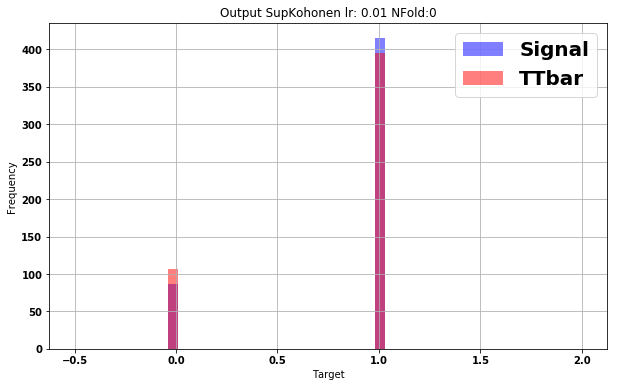

In [51]:
#choose_fold = 7

#train_id, test_id = CVO[choose_fold]

#Output = classifiers[choose_fold].predict(data)


fig = plt.figure(figsize=(10,6))
my_bins = np.linspace(-0.5,2, 50)
#print output_class.shape
plt.hist(class_final[trgt[test_id]==1],bins=my_bins,color='b',alpha=0.5,label='Signal')
plt.hist(class_final[trgt[test_id]==0],bins=my_bins,color='r',alpha=0.5,label='TTbar')
plt.legend(fontsize=20,loc='best')
plt.title('Output SupKohonen lr: '+str(trn_params.learning_rate)+' NFold:'+str(choose_fold))
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.grid()
#plt.savefig(path_tosave+'/'+'Output_SupKohonenNormalized_Silhouette.pdf')
plt.show()

In [46]:
print sum(class_final[trgt[test_id]==0]==0)

218


/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  if __name__ == '__main__':


In [40]:
lista =[i for i in range(3)]
lista

[0, 1, 2]

In [ ]:
import joblib 

joblib.dump(new_classifiers[choose_fold],path_tosave+'/'+'ultimoModelo.pk1')



In [ ]:
import joblib

model = joblib.load(path_tosave+'/'+'ultimoModelo.pk1')

model.sinapses